In [38]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('idb5yr.txt', delimiter="|")
df = pd.read_csv("joined_data.csv")

In [44]:
df = df.fillna(0)

In [45]:
print(df.shape)


(13696, 259)
(64, 69)


In [47]:
things_to_add = ["POP", "BIRTH", "DEATH"]

def add_previous_years(df):
    target_map = df['POP'].to_dict()
    df['lag1'] = (df.index - 1).map(target_map)
    df['lag2'] = (df.index - 2).map(target_map)
    df['lag3'] = (df.index - 3).map(target_map)
    df["lag1"].fillna(0, inplace=True)
    df["lag2"].fillna(0, inplace=True)
    df["lag3"].fillna(0, inplace=True)
    return df


def add_next_years(df):
    target_map = df['POP'].to_dict()
    df['lag1'] = (df.index + 1).map(target_map)
    df['lag2'] = (df.index + 2).map(target_map)
    df['lag3'] = (df.index + 3).map(target_map)
    df["goal"] = (df.index - 1).map(target_map)
    df["lag1"].fillna(0, inplace=True)
    df["lag2"].fillna(0, inplace=True)
    df["lag3"].fillna(0, inplace=True)
    df["goal"].fillna(0, inplace=True)
    return df


In [50]:
grouped = df.groupby('Code', as_index=False)
fixed = grouped.apply(add_previous_years)

In [51]:
new_frame = fixed.reset_index()
new_frame = new_frame.drop(["level_0", "level_1"], axis=1)

In [52]:
print(new_frame)

        Country  Year         Code  \
0       Andorra  1960  W140000WOAD   
1       Andorra  1961  W140000WOAD   
2       Andorra  1962  W140000WOAD   
3       Andorra  1963  W140000WOAD   
4       Andorra  1964  W140000WOAD   
...         ...   ...          ...   
13691  Zimbabwe  2019  W140000WOZW   
13692  Zimbabwe  2020  W140000WOZW   
13693  Zimbabwe  2021  W140000WOZW   
13694  Zimbabwe  2022  W140000WOZW   
13695  Zimbabwe  2023  W140000WOZW   

       EG.ELC.ACCS.ZS_Access to electricity (% of population)  \
0                                               0.000000        
1                                               0.000000        
2                                               0.000000        
3                                               0.000000        
4                                               0.000000        
...                                                  ...        
13691                                           0.463959        
13692                  

In [58]:
no_country_df = new_frame.drop(["Code", "Country"], axis=1)

In [59]:
valid_df = no_country_df[no_country_df["Year"] <= 2023]

In [60]:
print(valid_df.head())

   Year  EG.ELC.ACCS.ZS_Access to electricity (% of population)  \
0  1960                                                0.0        
1  1961                                                0.0        
2  1962                                                0.0        
3  1963                                                0.0        
4  1964                                                0.0        

   NY.ADJ.NNTY.KD.ZG_Adjusted net national income (annual % growth)  \
0                                                0.0                  
1                                                0.0                  
2                                                0.0                  
3                                                0.0                  
4                                                0.0                  

   NY.ADJ.NNTY.KD_Adjusted net national income (constant 2015 US$)  \
0                                                0.0                 
1                             

In [61]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [62]:
fold = 0
preds = []
scores = []
regs = []
for train_idx, val_idx in tss.split(valid_df):
    train = valid_df.iloc[train_idx]
    test = valid_df.iloc[val_idx]


    TARGET = 'POP'

    X_train = train.drop([TARGET], axis=1)
    y_train = train[TARGET]

    X_test = test.drop([TARGET], axis=1)
    y_test = test[TARGET]
    reg = DecisionTreeRegressor(random_state=0)
    reg.fit(X_train, y_train)
    regs.append(reg)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


#printing scores for each fold

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 0.0372
Fold scores:[0.07624719347786957, 0.01611443840284921, 0.019093786920788447]


In [64]:
grouped = new_frame.groupby("Code")

In [26]:
counter = 0
for country, group in grouped:
    print(f"Country: {country}")
    print(group["POP"])10
    print()  # Add a blank line for readability
    counter += 1
    good_form = group.drop(["GEO_ID", "POP"], axis=1)
    good_form = good_form[good_form["#YR"] <= 2023]
    y_pred = regs[1].predict(good_form)
    print(y_pred)
    if counter > 2:
        break

Country: W140000WOAD
0      52747
1      56475
2      59722
3      62559
4      63826
       ...  
106    52592
107    52256
108    51919
109    51582
110    51243
Name: POP, Length: 111, dtype: int64

[52747. 56475. 59722. 62559. 63826. 63245. 63358. 64053. 64728. 65073.
 65099. 65316. 65986. 68782. 73247. 76122. 78294. 80757. 82631. 83904.
 84563. 84888. 85164. 85389. 85563. 85690. 85771. 85811. 85813. 85782.
 85722. 85645. 85560. 85468.]
Country: W140000WOAE
111     2369781
112     2536143
113     2704660
114     2876234
115     3051363
         ...   
212    15024060
213    15055416
214    15085746
215    15115076
216    15143404
Name: POP, Length: 106, dtype: int64

[2369781. 2536143. 2704660. 2876234. 3051363. 3230742. 3402348. 3555027.
 3693043. 3819555. 3935820. 4458540. 5532409. 7159278. 8032709. 8020877.
 8302211. 8606553. 8930981. 9170474. 9308415. 9432801. 9543192. 9638206.
 9720156. 9792173. 9856612. 9915803. 9973449.]
Country: W140000WOAF
217    15555612
218    15044289
2

In [27]:
import pickle
with open("regtree", "bw") as f:
    pickle.dump(regs[1], f)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
countries = ["Viet Nam", "Russian Federation", "Rwanda", "Cambodia"]
#Here we do the back-prediction
grouped = df.groupby('Code', as_index=False)
fixed = grouped.apply(add_next_years)
new_frame = fixed.reset_index()
new_frame = new_frame.drop(["level_0", "level_1"], axis=1)
no_country_df = new_frame.drop(["Code", "Country"], axis=1)
valid_df = no_country_df[no_country_df["Year"] <= 2023]
fold = 0
preds = []
scores = []
train, test = train_test_split(valid_df, test_size=0.2)


TARGET = 'goal'
X_train = train.drop([TARGET], axis=1)
y_train = train[TARGET]

X_test = test.drop([TARGET], axis=1)
y_test = test[TARGET]
models = [DecisionTreeRegressor(random_state=0), RandomForestRegressor(n_estimators = 10), GradientBoostingRegressor(n_estimators = 10)]
finished_models = []
for reg in models:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    finished_models.append(reg)


#printing scores for each fold

print(f'Score across models {np.mean(scores):0.4f}')
print(f'Model scores:{scores}')


Score across models 0.0107
Model scores:[0.0033539503820195975, 0.003308069538783886, 0.025336893593866063]


In [71]:
clean_grouped = new_frame.groupby("Code")
counter = 0
for country, group in clean_grouped:
    print(f"Country: {country}")
    print(group["POP"])
    print()  # Add a blank line for readability
    counter += 1
    good_form = group.drop(["GEO_ID", "goal"], axis=1)
    good_form = good_form[good_form["#YR"] <= 2023]
    y_pred = regs[1].predict(good_form)
    print(y_pred)
    if counter > 2:
        break

Country: W140000WOAD
0     0.000004
1     0.000004
2     0.000005
3     0.000006
4     0.000007
        ...   
59    0.000059
60    0.000059
61    0.000059
62    0.000059
63    0.000059
Name: POP, Length: 64, dtype: float64



KeyError: "['GEO_ID'] not found in axis"

In [141]:
max = 1413142846
min = 2705
def get_pop(df):
    pop_list = df['POP'].tolist()
    pop_list = list(map(lambda x : unnormalize(x, max, min), pop_list))
    return pop_list

def unnormalize(value, max, min):
    return (max - min) * value + min
country_record = {}
country_pop = {}
for country in countries:
    country_frame = new_frame[new_frame["Country"] == country]
    good_form = country_frame.drop(["Country", "Code", "goal"], axis=1).iloc[::-1]
    
    goal_record = [[], [], []]
    for index, row in good_form.iterrows():
        if row["Year"] > 2020: continue
        #row = row.drop("goal")
        row_df = pd.DataFrame([row], columns = good_form.columns)
        for i in range(len(finished_models)):
            if goal_record[i]:
                row["lag1"] = goal_record[i][-1]
            goal_pred = finished_models[i].predict(row_df)
            goal_record[i].append(goal_pred)
    for i in range(len(goal_record)):
        goal_record[i] = list(map(lambda x : unnormalize(x, max, min), goal_record[i]))
    country_record[country] = goal_record
    country_pop[country] = get_pop(country_frame)


In [143]:
print(country_record)

{'Viet Nam': [[array([1.00669666e+08]), array([99578719.99999994]), array([97355564.99999987]), array([97355564.99999987]), array([96197850.99999996]), array([95031567.99999993]), array([93859917.99999994]), array([91568195.99999993]), array([91568195.99999993]), array([90458606.99999993]), array([86859532.99999991]), array([88230615.99999994]), array([86014940.99999988]), array([86014940.99999988]), array([84920496.99999987]), array([83800249.99999987]), array([82699693.]), array([81617016.99999997]), array([80525731.99999994]), array([79451865.99999991]), array([78374933.99999994]), array([77303764.99999988]), array([76214806.99999991]), array([75076985.99999996]), array([74081583.99999997]), array([72803614.99999994]), array([69811258.99999996]), array([69811258.99999996]), array([68657379.9999999]), array([67265920.99999987]), array([65868480.99999992]), array([64211346.99999993]), array([62826490.99999993]), array([60641898.99999989]), array([60641898.99999989]), array([58659970.9

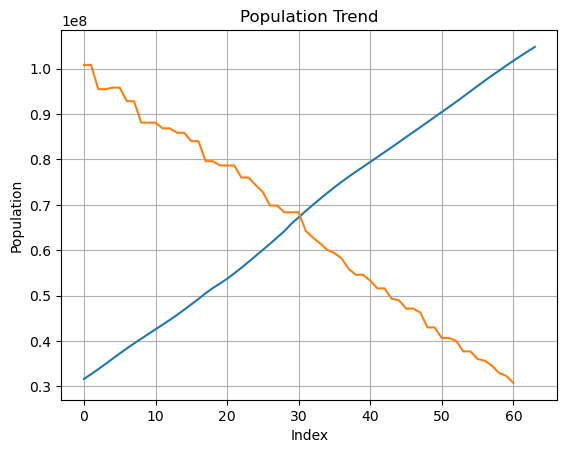

In [127]:
# Plot 'pop' column
plt.plot(country_pop[countries[0]])
plt.plot(country_record[countries[0]])
plt.xlabel('Index')
plt.ylabel('Population')
plt.title('Population Trend')
plt.grid(True)
plt.show()
